### Goal
Implement the several linear regression models and apply them on blood to muscle samples.

### TODO
   1. Simulated dataset
   2. 4 x regression models:<br/>
       2.1 Model1 $Y_i,g,t = beta_g_t*Y_i,g,t=blood$ <br/>
       2.2 Model2 $Y_i,g,t = beta_g_t*Y_i,g,t=blood + beta_zero$ <br/>
       2.3 <br/>
       2.3.1 Model3 $Y_i,g,t = beta_g_t*Y_i,g,t=blood + beta_zero + sum_k (alpha_t_k * P_i_k)$ <br/>
       2.3.2 Compute: $Y_i,g,t = sum_l (beta_t_l * Q_g_l)$ <br/>
       2.3.3 Compute: $Y_i,g,t = sum_k (alpha_t_k * P_i_k)$
           
       2.4 Model4 $Y_i,g,t = beta_g_t*Y_i,g,t=blood + beta_zero + sum_k (alpha_t_k * P_i_k) + sum_l (beta_t_l * Q_g_l)$, where g-gene, i-individual, t-tissue, k=0,n_comp_P-1, l=0,n_comp_Q-1<br/>
       2.5 Simulate large dataset using model4<br/>
   3. Apply model 4 on the real data
   4. Fit data using robust regression:
      - This approach changes the model 4 in the sense that another loss_function (L1-norm loss) or another estimator (HuberRegressor) is used


In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import comet_ml
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LassoLarsCV, Lasso, LinearRegression, RidgeCV, SGDRegressor, LassoLars, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

from scipy.stats import spearmanr, pearsonr
from scipy.stats import nbinom

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from joblib import dump, load

np.random.seed(1)

### 1. Simulate data

In [6]:
# fix values
n_genes = 10
n_indiv = 30
n_indiv_effect = 2
n_gene_effect = 2
def simulate_data(n_genes_, n_indiv_, n_indiv_effect_, n_gene_effect_):
    pca_type = PCA

    # input
    y_blood_ = np.random.uniform(low=-6, high=6, size=(n_indiv_,n_genes_))

    # PCA - individual effect
    s = StandardScaler()
    ys_blood = s.fit_transform(y_blood_)
    pca = pca_type(n_components=n_indiv_effect_)
    # indiv effect
    P_ = pca.fit_transform(ys_blood)

    # PCA - gene effect
    s = StandardScaler()
    ys_blood = s.fit_transform(y_blood_.T)
    pca = pca_type(n_components=n_gene_effect_)
    # gene effect
    Q_ = pca.fit_transform(ys_blood)

    print(f'P_shape = {P_.shape}, Q_shape={Q_.shape}, input_shape={y_blood_.shape}')

    # values to approximate
    beta_zero_ = 0.001
    alphas_ = np.random.uniform(-1,1,size=n_indiv_effect_)
    betas_ = np.random.uniform(-1,1,size=n_gene_effect_)
    tetas_ = np.random.uniform(-1,1,size=n_genes_)

    tetas_matrix_ = np.zeros((n_genes_,n_genes_))
    tetas_matrix_= np.diag(tetas_)

    # final output Y_i,g,t = beta_g_t*Y_i,g,t=blood + beta_zero + sum_k (alpha_t_k * P_i_k) + sum_l (beta_t_l * Q_g_l)
    y_out_ = y_blood_@tetas_matrix_  + beta_zero_ + np.tile((P_@alphas_).reshape(n_indiv_,1),(1,n_genes_)) + np.tile((Q_@betas_).T.reshape(1,n_genes_),(n_indiv_,1))
    print(f'out_shape={y_out_.shape}')
    
    return (y_blood_, beta_zero_, alphas_, betas_, tetas_, tetas_matrix_, P_, Q_)

(y_blood, beta_zero, alphas, betas, tetas, tetas_matrix, P, Q) = simulate_data(n_genes, n_indiv, n_indiv_effect, n_gene_effect)

P_shape = (30, 2), Q_shape=(10, 2), input_shape=(30, 10)
out_shape=(30, 10)


### 2. Regression models
#### 2.1. Compute : $Y_i,g,t=beta_g_t*Y_i,g,t=blood$, i=individual, g=gene, t=tissue. 

In [52]:
y_out = y_blood@tetas_matrix
lm_array = []

print("Fitted Param:")
for gene in range(n_genes):
    X = y_blood[:,gene].reshape(-1, 1)
    y = y_out[:,gene].reshape(-1, 1)
    lm = LinearRegression(fit_intercept=False).fit(X,y)
    lm_array.append(lm)
    print(lm.coef_)
print("\nComputed Param:")
print(tetas)

# predict
y_pred = np.zeros(y_out.shape)
for i,lm in enumerate(lm_array):
    y_pred[:,i] = lm.predict(y_blood[:,i].reshape(-1, 1)).squeeze()

print("\nObs")
print(y_out[:3,:3])
print("\nPred")
print(y_pred[:3,:3])
print("\nObs-Pred=")
print(np.sum(abs(y_out-y_pred)/abs(y_out)))

Fitted Param:
[[-0.67805713]]
[[-0.06623995]]
[[-0.3096559]]
[[-0.54992008]]
[[0.18502374]]
[[-0.37546032]]
[[0.83261111]]
[[0.81927105]]
[[-0.48576341]]
[[-0.7782174]]

Computed Param:
[-0.67805713 -0.06623995 -0.3096559  -0.54992008  0.18502374 -0.37546032
  0.83261111  0.81927105 -0.48576341 -0.7782174 ]

Obs
[[ 0.67516585 -0.17513141  1.85751038]
 [ 0.65748882 -0.14722718  1.09821725]
 [-2.44706398 -0.37221151  0.69329164]]

Pred
[[ 0.67516585 -0.17513141  1.85751038]
 [ 0.65748882 -0.14722718  1.09821725]
 [-2.44706398 -0.37221151  0.69329164]]

Obs-Pred=
3.4936021792176384e-14


#### 2.2. Compute: $Y_i,g,t=beta_g_t*Y_i,g,t=blood + beta_zero$ and optimize the computation using parallelization

In [2]:
from joblib import Parallel, delayed

def train_model(X_, y_, fit_intercept=True):
    m = Ridge(fit_intercept=fit_intercept)
    return m.fit(X_, y_)

def model2(X,y,size_genes, fit_intercept):
    lm_array = []
    lm_array = Parallel(n_jobs=4)(delayed(train_model)(X[:,gene].reshape(-1,1), y[:,gene].reshape(-1,1), fit_intercept) for gene in range(size_genes))
    return lm_array

def predict_model2(model, X):
    y_first = model[0].predict(X[:,0].reshape(-1,1))
    y_pred = np.zeros((y_first.shape[0], len(model)))
    y_pred[:,0] = y_first.squeeze()
    for i in range(1,len(model)):
        y_pred[:,i] = (model[i].predict(X[:,i].reshape(-1,1))).squeeze()
    return y_pred

def coef_model2(model):
    print("\nFitted Param:")
    print("Tetas: ")
    for lm in model: print(f'coef={lm.coef_};intercept={lm.intercept_}')
    print("")

In [6]:
# true output
y_out = y_blood@tetas_matrix + beta_zero

# fit  
model_obj = model2(y_blood,y_out,n_genes,fit_intercept=True)

# predict
y_pred = predict_model2(model_obj,y_blood)
                   
# print coeficients
coef_model2(model_obj)

print("\nComputed Param:")
print(tetas)
print(beta_zero)

print("\nObs")
print(y_out[:3,:3])
print("\nPred")
print(y_pred[:3,:3])
print("\nObs-Pred=")
print(np.sum(y_out-y_pred))


Fitted Param:
Tetas: 
coef=[[-0.67805713]];intercept=[0.001]
coef=[[-0.06623995]];intercept=[0.001]
coef=[[-0.3096559]];intercept=[0.001]
coef=[[-0.54992008]];intercept=[0.001]
coef=[[0.18502374]];intercept=[0.001]
coef=[[-0.37546032]];intercept=[0.001]
coef=[[0.83261111]];intercept=[0.001]
coef=[[0.81927105]];intercept=[0.001]
coef=[[-0.48576341]];intercept=[0.001]
coef=[[-0.7782174]];intercept=[0.001]


Computed Param:
[-0.67805713 -0.06623995 -0.3096559  -0.54992008  0.18502374 -0.37546032
  0.83261111  0.81927105 -0.48576341 -0.7782174 ]
0.001

Obs
[[ 0.67616585 -0.17413141  1.85851038]
 [ 0.65848882 -0.14622718  1.09921725]
 [-2.44606398 -0.37121151  0.69429164]]

Pred
[[ 0.67616585 -0.17413141  1.85851038]
 [ 0.65848882 -0.14622718  1.09921725]
 [-2.44606398 -0.37121151  0.69429164]]

Obs-Pred=
7.27456289650874e-15


#### 2.3.1 Compute: $Y_i,g,t = beta_g_t*Y_i,g,t=blood + beta_zero + sum_k (alpha_k_t * P_i_k)$
For this model we need to estimate:
- the tissue specific intercept (beta_zero) 
- the coeficients (alphas) for the individual effect (P matrix)
- the weights for each gene-tissue (beta_g_t)

In [7]:
# true output
y_out = y_blood@tetas_matrix  + beta_zero + np.tile((P@alphas).reshape(n_indiv,1),(1,n_genes))

def train_model_ridge(X_, y_, fit_intercept=True):
    m = Ridge(fit_intercept=fit_intercept,alpha=0.99)
    return m.fit(X_, y_)

def train_model_lasso(X_, y_, fit_intercept=True):
    m = LassoLars(fit_intercept=fit_intercept,alpha=0.5)
    return m.fit(X_, y_)


def model3(X,X_P,y,size_genes, fit_intercept):
    lm_array = []
    lm_array = Parallel(n_jobs=32)(delayed(train_model_ridge)(np.concatenate((X_P, X[:,gene].reshape(-1,1)), axis=1), y[:,gene].reshape(-1,1), fit_intercept) for gene in range(size_genes))
    return lm_array

def predict_model3(model, X, X_P):
    y_first = model[0].predict(np.concatenate((X_P, X[:,0].reshape(-1,1)), axis=1))
    y_pred = np.zeros((y_first.shape[0], len(model)))
    y_pred[:,0] = y_first.squeeze()
    for i in range(1,len(model)):
        y_pred[:,i] = (model[i].predict(np.concatenate((X_P, X[:,i].reshape(-1,1)), axis=1))).squeeze()
    return y_pred

def coef_model3(model):
    print("\nFitted Param:")
    print("Tetas: ")
    for lm in model: print(f'coef={lm.coef_};intercept={lm.intercept_}')
    print("") 
    
# fit
model = model3(y_blood,P,y_out,n_genes, fit_intercept = True)
# predict
y_pred = predict_model3(model,y_blood,P)
# coef
coef_model3(model)

print("\nComputed Param:")
print("Tetas ",tetas)
print("Beta_zero ", beta_zero)
print("Alphas ",alphas)

print("\nObs")
print(y_out[:3,:3])
print("\nPred")
print(y_pred[:3,:3])



Fitted Param:
Tetas: 
coef=[[ 0.61429763  0.73413884 -0.67617651]];intercept=[0.00267174]
coef=[[ 0.61433227  0.73232779 -0.06415222]];intercept=[-0.00149464]
coef=[[ 0.60677087  0.7357615  -0.30483432]];intercept=[0.00040583]
coef=[[ 0.61548938  0.72962053 -0.54532285]];intercept=[0.00249656]
coef=[[0.59183994 0.71129463 0.19962433]];intercept=[0.01001203]
coef=[[ 0.60723561  0.73559924 -0.37079906]];intercept=[-0.00031685]
coef=[[0.60964258 0.7371216  0.82888119]];intercept=[-0.00212567]
coef=[[0.61798449 0.71322881 0.80668217]];intercept=[0.00804323]
coef=[[ 0.61459241  0.73151552 -0.48772053]];intercept=[0.0017634]
coef=[[ 0.57565693  0.72349042 -0.75876495]];intercept=[-0.02111024]


Computed Param:
Tetas  [-0.67805713 -0.06623995 -0.3096559  -0.54992008  0.18502374 -0.37546032
  0.83261111  0.81927105 -0.48576341 -0.7782174 ]
Beta_zero  0.001
Alphas  [0.6237174  0.74992329]

Obs
[[-0.31079402 -1.16109128  0.87155051]
 [-0.22202064 -1.02673664  0.21870778]
 [ 0.46493827  2.539790

#### 2.3.2 Compute: $Y_i,g,t = sum_l (beta_t_l * Q_g_l)$

In [8]:
y_out = np.tile((Q@betas).reshape(1,n_genes),(n_indiv,1))

In [3]:
def model_Q(X,y,fit_intercept):
    return Ridge(fit_intercept=fit_intercept, alpha=0.99).fit(X, y)

def predict_model_Q(model, X):
    return model.predict(X)


def model_Q_mean(X, y, size_indiv, fit_intercept):
    lm_array = []
    coef = []
    intercept = []
    
    lm_array = Parallel(n_jobs=32)(delayed(model_Q)(X, y[indiv,:].flatten(), fit_intercept) for indiv in range(size_indiv))
    
    for lm in lm_array:
        coef.append(lm.coef_)
        intercept.append(lm.intercept_)
    
    reg = Ridge(fit_intercept = fit_intercept, alpha=0.99)
    reg.coef_ = np.mean(np.array(coef),axis=0)
    reg.intercept_ = np.mean(np.array(intercept))    
    
    return reg
    
def predict_model_Q_mean(model, X, size_indiv):
    return np.tile(model.predict(X).reshape(1,-1), (size_indiv, 1))

def coef_model_Q(model):
    print("\nFitted Param:")
    print("Betas: ")
    print(f'coef={model.coef_};intercept={model.intercept_}')

In [8]:
# fit
matrix_Q = np.tile(Q,(n_indiv,1))
model = model_Q(matrix_Q, y_out.flatten(), fit_intercept = False)
# predict
y_pred = predict_model_Q(model, matrix_Q)
# coef
coef_model_Q(model)

print("\nComputed Param:")
print("Betas ",betas)


print("\nObs")
print(y_out[:3,:3])
print("\nPred")
print(y_pred.reshape(n_indiv, n_genes)[:3,:3])


# mean of linear regresssion per indiv
print("\n\nMean over linear regression per individual")
model = model_Q_mean(Q, y_out, n_indiv, fit_intercept = False)
y_pred = predict_model_Q_mean(model,Q, n_indiv)
coef_model_Q(model)


Fitted Param:
Betas: 
coef=[0.37662834 0.13890318];intercept=0.0

Computed Param:
Betas  [0.3768265  0.13898883]

Obs
[[ 0.43092844  0.574875   -0.77468086]
 [ 0.43092844  0.574875   -0.77468086]
 [ 0.43092844  0.574875   -0.77468086]]

Pred
[[ 0.43073245  0.5745585  -0.77427252]
 [ 0.43073245  0.5745585  -0.77427252]
 [ 0.43073245  0.5745585  -0.77427252]]


Mean over linear regression per individual

Fitted Param:
Betas: 
coef=[0.370971   0.13646459];intercept=0.0


#### 2.3.3 Compute: $Y_i,g,t = sum_k (alpha_t_k * P_i_k)$

In [9]:
y_out =  np.tile((P@alphas).reshape(n_indiv,1),(1,n_genes))

In [4]:
def model_P(X,y,fit_intercept):
    return Ridge(fit_intercept=fit_intercept, alpha=0.99).fit(X, y)

def model_P_mean(X, y, size_genes, fit_intercept):
    lm_array = []
    coef = []
    intercept = []
    
    lm_array = Parallel(n_jobs=32)(delayed(model_P)(X, y[:,gene], fit_intercept) for gene in range(size_genes))
    
    coef = lm_array[0].coef_
    for lm in lm_array:
        coef = np.vstack([coef, lm.coef_])
        intercept.append(lm.intercept_)

    reg = Ridge(fit_intercept = fit_intercept, alpha=0.99)
    reg.coef_ = np.mean(coef,axis=0)
    reg.intercept_ = np.mean(np.array(intercept))    
    
    return reg
    
def predict_model_P_mean(model,X, size_genes):
    return np.tile(model.predict(X).reshape(-1,1), (1, size_genes))

def predict_model_P(model,X):
    return model.predict(X)

def coef_model_P(model):
    print("\nFitted Param:")
    print("Aphas: ")
    print(f'coef={model.coef_};intercept={model.intercept_}')

In [9]:
# fit
model = model_P_mean(P, y_out, n_genes, fit_intercept = False)
# predict
y_pred = predict_model_P_mean(model, P, n_genes)
# coef
coef_model_P(model)

print("\nComputed Param:")
print("Alphas ",alphas)

print("\nObs")
print(y_out[:3,:3])
print("\nPred")
print(y_pred[:3,:3])


Fitted Param:
Aphas: 
coef=[0.61392193 0.73461087];intercept=0.0

Computed Param:
Alphas  [0.6237174  0.74992329]

Obs
[[-0.98695987 -0.98695987 -0.98695987]
 [-0.88050947 -0.88050947 -0.88050947]
 [ 2.91100224  2.91100224  2.91100224]]

Pred
[[-0.97187149 -0.97187149 -0.97187149]
 [-0.8680323  -0.8680323  -0.8680323 ]
 [ 2.85506791  2.85506791  2.85506791]]


#### 2.4. Compute $Y_i,g,t = beta_g_t*Y_i,g,t=blood + beta_zero + sum_k (alpha_t_k * P_i_k) + sum_l (beta_t_l * Q_g_l)$
Compute the model using the big model (to check if the formula its correct) and then interatively (make it fast)

In [7]:
############################################################## Big model

# final output Y_i,g,t = beta_g_t*Y_i,g,t=blood + beta_zero + sum_k (alpha_t_k * P_i_k) + sum_l (beta_t_l * Q_g_l)
y_out = y_blood@tetas_matrix  + beta_zero + np.tile((P@alphas).reshape(n_indiv,1),(1,n_genes)) + np.tile((Q@betas).reshape(1,n_genes),(n_indiv,1))

def model4(X,X_P,X_Q,y,size_genes, size_indiv, fit_intercept):
    Q_block = np.tile(X_Q,(size_indiv,1))
    
    P_block = np.repeat(P, repeats=size_genes, axis=0)
    
    X_block = np.diag(X[0,:])
    for row in range(1, X.shape[0]): X_block = np.vstack([X_block,np.diag(X[row,:])])
        
    print(Q_block.shape,P_block.shape,X_block.shape, y.flatten().shape)
    
    model = LinearRegression(fit_intercept=fit_intercept).fit(np.hstack([Q_block,P_block,X_block]),y.flatten())
    
    return model


def predict_model4(model, X, X_P, X_Q, size_indiv, size_genes):
    
    Q_block = np.tile(X_Q,(size_indiv,1))
    
    P_block = np.repeat(P, repeats=size_genes, axis=0)
    
    X_block = np.diag(X[0,:])
    for row in range(1, X.shape[0]): X_block = np.vstack([X_block,np.diag(X[row,:])])
    
    return model.predict(np.hstack([Q_block,P_block,X_block]))

def coef_model4(model):
    print("\nFitted Param:")
    print(f'Betas:{model.coef_[:2]}')
    print(f'Alphas:{model.coef_[2:4]}')
    print(f'Tetas:{model.coef_[4:]}')
    print(f'Beta_zero:{model.intercept_}')
    
# fit
model = model4(y_blood, P, Q, y_out, n_genes, n_indiv, fit_intercept = True)
# predict
y_pred = predict_model4(model, y_blood, P, Q, n_indiv, n_genes)
# coef
coef_model4(model)

print("\nComputed Param:")
print("Tetas ",tetas)
print("Beta_zero ", beta_zero)
print("Alphas ",alphas)
print("Betas ",betas)


print("\nObs")
print(y_out[:3,:3])
print("\nPred")
print(y_pred.reshape(n_indiv, n_genes)[:3,:3])

(300, 2) (300, 2) (300, 10) (300,)

Fitted Param:
Betas:[0.3768265  0.13898883]
Alphas:[0.6237174  0.74992329]
Tetas:[-0.67805713 -0.06623995 -0.3096559  -0.54992008  0.18502374 -0.37546032
  0.83261111  0.81927105 -0.48576341 -0.7782174 ]
Beta_zero:0.0010000000000000286

Computed Param:
Tetas  [-0.67805713 -0.06623995 -0.3096559  -0.54992008  0.18502374 -0.37546032
  0.83261111  0.81927105 -0.48576341 -0.7782174 ]
Beta_zero  0.001
Alphas  [0.6237174  0.74992329]
Betas  [0.3768265  0.13898883]

Obs
[[ 0.12013442 -0.58621628  0.09686965]
 [ 0.2089078  -0.45186164 -0.55597308]
 [ 0.89586671  3.11466574  2.83061302]]

Pred
[[ 0.12013442 -0.58621628  0.09686965]
 [ 0.2089078  -0.45186164 -0.55597308]
 [ 0.89586671  3.11466574  2.83061302]]


In [11]:
############################################################## Iterative fitting
np.random.seed(0)

# final output Y_i,g,t = beta_g_t*Y_i,g,t=blood + beta_zero + sum_k (alpha_t_k * P_i_k) + sum_l (beta_t_l * Q_g_l)
y_out = y_blood@tetas_matrix  + beta_zero + np.tile((P@alphas).reshape(n_indiv,1),(1,n_genes)) + np.tile((Q@betas).reshape(1,n_genes),(n_indiv,1))

In [12]:
def compute_loss(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [14]:
def model4(X, X_P, X_Q, y, size_genes, size_indiv, title_loss = "Loss"):
    
    model_dict = {
        'P':None,
        'Q':None,
        'model2':None
    }
    
    q_pred = np.zeros(y.shape)
    p_pred = np.zeros(y.shape)
    model2_pred = np.zeros(y.shape)
    
    loss = 0
    epsilon = 0.0001
    i = 0
    
    # loss - total, partial loss for P (indiv effect), Q (gene effect) and model2 (gene-tissue variance) 
    x_plot=[]
    y_plot=[]
    q_plot=[]
    p_plot=[]
    model2_plot=[]
    
    y_flat = y.flatten()
    X_P_block = np.repeat(X_P, repeats=size_genes, axis=0) 
    X_Q_block = np.tile(X_Q,(size_indiv,1))
    
    while(True):
        i += 1
        
        # fit partial models
        m_p = model_P(X_P_block, (y - q_pred - model2_pred).flatten(), fit_intercept = False)
        m_q = model_Q(X_Q_block, (y - p_pred - model2_pred).flatten(), fit_intercept = True)
        m_model2 = model2(X, y - p_pred - q_pred , size_genes, fit_intercept = False)
      
        # predict
        q_pred = predict_model_Q(m_q, X_Q_block).reshape((size_indiv, size_genes))
        p_pred = predict_model_P(m_p, X_P_block).reshape((size_indiv, size_genes))        
        model2_pred = predict_model2(m_model2, X) 
        
#         loss = compute_loss(y,gene_effect_pred.reshape(size_indiv, size_genes) + indiv_effect_pred)
        # loss MSE
        loss = compute_loss(y, q_pred + p_pred + model2_pred)
        x_plot.append(i)
        y_plot.append(loss)
        
        # partial loss
        q_plot.append(compute_loss(y,q_pred))
        p_plot.append(compute_loss(y,p_pred))
        model2_plot.append(compute_loss(y,model2_pred))
        
        if len(y_plot)>=2 and abs(y_plot[-1] - y_plot[-2]) <= epsilon:
            break

    # save model
    model_dict = {
        'P':m_p,
        'Q':m_q,
        'model2':m_model2
    }
    
    plt.ioff()## Note this correction
    fig=plt.figure()
    #    plt.axis([0,i,0,np.max(y_plot)+0.2])
    plt.plot(x_plot,y_plot)
#     plt.plot(x_plot,q_plot)
#     plt.plot(x_plot,p_plot)
#     plt.plot(x_plot,model2_plot)
#     plt.semilogy()
    plt.legend(['loss'], loc='upper left')
#     plt.legend(['loss', 'Q_loss', 'P_loss', 'X_loss'], loc='upper left')
    plt.title(title_loss)
    plt.show()
    
    return model_dict

def predict_model4(model, X, X_P, X_Q, size_genes, size_indiv):

    X_P_block = np.repeat(X_P, repeats=size_genes, axis=0) 
    X_Q_block = np.tile(X_Q,(size_indiv,1))    
    
    predq = predict_model_Q(model['Q'],X_Q_block).reshape((size_indiv, size_genes))
    predp = predict_model_P(model['P'],X_P_block).reshape((size_indiv, size_genes))
    predx = predict_model2(model['model2'],X)
    return predq + predp + predx
    
def coef_model4(model):
    coef_model_Q(model["Q"])
    coef_model_P(model["P"])
#     coef_model2(model["model2"])

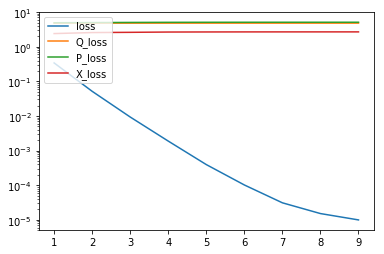

CPU times: user 1.21 s, sys: 111 ms, total: 1.32 s
Wall time: 4.25 s

Fitted Param:
Betas: 
coef=[0.37666972 0.13893312];intercept=0.0008436201002992924

Fitted Param:
Aphas: 
coef=[0.62198159 0.7480689 ];intercept=0.0

Fitted Param:
Tetas: 
coef=[[-0.67807816]];intercept=0.0
coef=[[-0.06601767]];intercept=0.0
coef=[[-0.30917335]];intercept=0.0
coef=[[-0.54971777]];intercept=0.0
coef=[[0.18591457]];intercept=0.0
coef=[[-0.37500335]];intercept=0.0
coef=[[0.83235817]];intercept=0.0
coef=[[0.81881869]];intercept=0.0
coef=[[-0.48608933]];intercept=0.0
coef=[[-0.77746856]];intercept=0.0


Computed Param:
Betas  [0.3768265  0.13898883]
Alphas  [0.6237174  0.74992329]
Tetas  [[-0.67805713]
 [-0.06623995]
 [-0.3096559 ]
 [-0.54992008]
 [ 0.18502374]
 [-0.37546032]
 [ 0.83261111]
 [ 0.81927105]
 [-0.48576341]
 [-0.7782174 ]]
Beta_zero  0.001


In [13]:
# fit
%time model = model4(y_blood, P, Q, y_out, n_genes, n_indiv)
y_pred = predict_model4(model, y_blood , P, Q, n_genes, n_indiv)
coef_model4(model)
print("\nComputed Param:")
print("Betas ",betas)
print("Alphas ",alphas)
print("Tetas ",tetas.reshape(-1,1))
print("Beta_zero ", beta_zero)

#### 2.5 Simulate large dataset using model4

In [14]:
n_indiv = 300
n_genes = 20000
(y_blood, beta_zero, alphas, betas, tetas, tetas_matrix, P, Q) = simulate_data(n_genes, n_indiv, 10, 10)

P_shape = (300, 10), Q_shape=(20000, 10), input_shape=(300, 20000)
out_shape=(300, 20000)


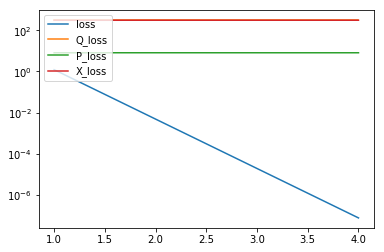

CPU times: user 6min 32s, sys: 27.3 s, total: 6min 59s
Wall time: 40.5 s


In [15]:
y_out = y_blood@tetas_matrix  + beta_zero + np.tile((P@alphas).reshape(n_indiv,1),(1,n_genes)) + np.tile((Q@betas).reshape(1,n_genes),(n_indiv,1))

# fit
%time model = model4(y_blood, P, Q, y_out, n_genes, n_indiv)
# predict
y_pred = predict_model4(model, y_blood , P, Q, n_genes, n_indiv)
# coef_model4(model)

In [16]:
print("loss", compute_loss(y_out, y_pred))

loss 7.472508259397689e-08


### 3. Apply model 4 on the real data

#### 3.1 Prepare the data

In [3]:
%reload_ext autoreload
%autoreload 2
import numpy as np

import numpy as np
import pandas as pd
import re

import comet_ml
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LassoLarsCV, Lasso, LinearRegression, RidgeCV, SGDRegressor, LassoLars, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

from scipy.stats import spearmanr, pearsonr
from scipy.stats import nbinom

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from joblib import dump, load


import rep
import rep.preprocessing_new as prep
import rep.datasets as d
import rep.linear_regression as lr
import rep.metrics as metrics
from anndata import AnnData

IndentationError: expected an indented block (linear_regression.py, line 241)

In [20]:
# load train valida data
path = "/s/project/rep/"
# path = "/home/mada/Uni/Masterthesis/online_repo/rep/data/"
y_targets_h5 = path + "processed/gtex/input_data/Y_targets_pc_onlyblood.h5"
x_inputs_h5 =  path + "processed/gtex/input_data/X_inputs_pc_onlyblood.h5"
train_dataset, valid_dataset = d.rep_blood_expression(x_inputs_h5, y_targets_h5, label=None)

metadata_samples_train, metadata_samples_valid = train_dataset.metadata, valid_dataset.metadata
features_train, features_valid = train_dataset.features, valid_dataset.features
x_train, y_train = train_dataset.inputs, train_dataset.targets
x_valid, y_valid = valid_dataset.inputs, valid_dataset.targets

# load gtex data
features_file = path + "processed/gtex/recount/recount_gtex_logratios.h5ad"
train_individuals_file = path + "processed/gtex/recount/train_individuals.txt"
train_individuals = prep.read_csv_one_column(train_individuals_file)

valid_individuals_file = path + "processed/gtex/recount/valid_individuals.txt"
valid_individuals = prep.read_csv_one_column(valid_individuals_file)

gtex = prep.RepAnnData.read_h5ad(features_file)
gtex_filtered = gtex[gtex.samples['Individual'].isin(train_individuals + valid_individuals)]
gtex_filtered_train = gtex[gtex.samples['Individual'].isin(train_individuals)]

# gtex log2(TPM)
gtex_tpm = prep.RepAnnData.read_h5ad(path + "processed/gtex/recount/recount_gtex_norm_tmp.h5ad")
gtex_filtered_train_tmp = gtex_tpm[gtex_tpm.samples['Individual'].isin(train_individuals)]
gtex_filtered_train_tmp.X = np.log2(gtex_filtered_train_tmp.X + 1)
del gtex

In [21]:
# compute PCA - individual effect
def pca_individual_effect(gtex, n_comp = 95, tissue = 'Whole Blood', pca_type = PCA):
    slice_blood = gtex[gtex.obs['Tissue'] == tissue]
    metadata = slice_blood.obs
    features = slice_blood.X
    print(features.shape)
    if features.shape[0] >= n_comp:
        features_centered  = StandardScaler().fit_transform(features)
        pca = pca_type(n_components=n_comp)
        features_pca = pca.fit_transform(features_centered)
    
    # wrap PCA into AnndataObject
    return AnnData(X=features_pca, obs=metadata)

%time P_blood_all  = pca_individual_effect(gtex_filtered)
P_train_unsorted = P_blood_all[P_blood_all.obs['Individual'].isin(train_individuals)]
P_valid_unsorted = P_blood_all[P_blood_all.obs['Individual'].isin(valid_individuals)]

(331, 19932)
CPU times: user 24.6 s, sys: 5.18 s, total: 29.7 s
Wall time: 1.07 s


In [22]:
P_blood_all.X.shape, P_train_unsorted.X.shape, P_valid_unsorted.X.shape

((331, 95), (238, 95), (93, 95))

In [23]:
len(P_train_unsorted.obs['Individual'].drop_duplicates().tolist())

225

In [24]:
def sort_by_individual(anndata, sorter_list, column):
    
    df = pd.DataFrame(anndata.X,index=anndata.obs.index.tolist())
    df = pd.concat([df, anndata.obs], axis=1, join_axes=[df.index])

    # keep only one entry
    already_visited=[]
    to_keep = []

    for i in range(df.shape[0]):
        indiv = df['Individual'].iloc[i]        
        if indiv in sorter_list and indiv not in already_visited:
            to_keep.append(i)
            already_visited.append(indiv)

    df = df.iloc[to_keep,:]
    
    df.sort_values(['Individual'], ascending = [sorter_list], inplace=True)
    
    anndata_new = AnnData(X=df.iloc[:,:anndata.X.shape[1]], obs=df.iloc[:,anndata.X.shape[1]:], var=anndata.var)
    anndata_new.obs = df.iloc[:,anndata.X.shape[1]:]
    anndata_new.var = anndata.var

    # sort matrix according to index
    return anndata_new

In [25]:
# compute PCA - gene effect
def pca_gene_effect(gtex, n_comp = 26, pca_type = PCA):
    metadata = gtex.var
    features = gtex.X.transpose()

    if features.shape[0] >= n_comp:
        features_centered  = StandardScaler().fit_transform(features)
        pca = pca_type(n_components=n_comp)
        features_pca = pca.fit_transform(features_centered)
    return pd.DataFrame(features_pca, index=metadata)

Q = pca_gene_effect(gtex_filtered_train)
Q_tpm_only = pca_gene_effect(gtex_filtered_train_tmp)

In [26]:
def get_linear_regression_data(tissue, mt_train, mt_valid, x_train, y_train, x_valid, y_valid):
    
    # Filter by tissue
    index_train = np.where(mt_train['To_tissue'] == tissue)[0]
    index_valid = np.where(mt_valid['To_tissue'] == tissue)[0]

    xs_train = x_train[index_train,:]
    xs_valid = x_valid[index_valid,:]
    ys_train = y_train[index_train,:]
    ys_valid = y_valid[index_valid,:]
    
    mt_train_filtered = mt_train.iloc[index_train,:]
    mt_valid_filtered = mt_valid.iloc[index_valid,:]
    
#     print(xs_train.shape, mt_train_filtered.shape)
    
    unique_indiv_train = mt_train_filtered['Individual'].drop_duplicates().tolist()
    visited_train = []
    to_keep_train = []
   
    for i in range(xs_train.shape[0]):
        indiv = mt_train_filtered['Individual'].iloc[i]
        if indiv not in visited_train:
            to_keep_train.append(i)
            visited_train.append(indiv)
    index_train = to_keep_train
    
    unique_indiv_valid = mt_valid_filtered['Individual'].drop_duplicates().tolist()
    visited_valid = []
    to_keep_valid = []
    for i in range(xs_valid.shape[0]):
        indiv = mt_valid_filtered['Individual'].iloc[i]
        if indiv not in visited_valid:
            to_keep_valid.append(i)
            visited_valid.append(indiv)
    index_valid = to_keep_valid

    
    xs_train = xs_train[index_train,:]
    xs_valid = xs_valid[index_valid,:]
    ys_train = ys_train[index_train,:]
    ys_valid = ys_valid[index_valid,:]
    
    xs_train = xs_train.astype(np.float32) + 0.0001
    ys_train = ys_train.astype(np.float32) + 0.0001

    xs_valid = xs_valid.astype(np.float32) + 0.0001
    ys_valid = ys_valid.astype(np.float32) + 0.0001

    
    mt_train_filtered = mt_train_filtered.iloc[index_train,:]
    mt_valid_filtered = mt_valid_filtered.iloc[index_valid,:]

    
    return (xs_train, ys_train, mt_train_filtered), (xs_valid, ys_valid, mt_valid_filtered)

In [27]:
def run_linear_model(from_tissue_label, mt_train, mt_valid, x_train, y_train, x_valid, y_valid, model_name, estimator, loss_function, P_train_u, P_valid_u, Q_u, title_loss_u, path_models="/s/project/rep/processed/models/linear_regression/"):
    
    # rank tissues by the number of samples
    count_samples = mt_train[['From_tissue','To_tissue']].groupby('To_tissue').count().sort_values('From_tissue',ascending=False)[:30]
    
    # top 3
    tissues = count_samples.index[:3]

    # evaluation metrics
    """
    "blood" : {
        "muscle": {
            "train": {
                "loss" :
                "metrics"
            },
            "valid":{
                "loss":
                "metrics"
            }
        }
    }
    """ 
    dict_evaluation = {}
    dict_evaluation['blood'] = {}

    # assume prediction from blood to other tissues 
    for t in tissues:

        dict_evaluation[from_tissue_label][t] = {}
        dict_evaluation[from_tissue_label][t]['train'] = {}
        dict_evaluation[from_tissue_label][t]['valid'] = {}

        (x_train_, y_train_, meta_train), (x_valid_, y_valid_, meta_valid) = lr.get_linear_regression_data(t,
                                                                                                      mt_train,
                                                                                                      mt_valid,
                                                                                                      x_train,
                                                                                                      y_train,
                                                                                                      x_valid,
                                                                                                      y_valid)
        # filter and sort P by tissue and individuals
        P_train = lr.sort_by_individual(P_train_u, meta_train['Individual'].drop_duplicates().tolist(), 'Individual')
        P_valid = lr.sort_by_individual(P_valid_u, meta_valid['Individual'].drop_duplicates().tolist(), 'Individual')

        # fit
        n_indiv, n_genes = x_train_.shape
        model = m.model4(x_train_, np.array(P_train.X).astype(np.float32), Q_u.values.astype(np.float32), y_train_, n_genes, n_indiv, title_loss = title_loss_u + t, loss_function=loss_function, estimator=estimator)

        # save model
        tissue_name = t.lower().replace(" ","")
        tissue_name = re.sub("[-\(\)]","_", tissue_name)
        tissue_model_path = f'{path_models}{from_tissue_label}2{tissue_name}_{model_name}.joblib'
        dump(model, tissue_model_path)
        dict_evaluation[from_tissue_label][t]['model'] = tissue_model_path

        # predict on train
        n_indiv, n_genes = x_train_.shape
        y_pred = m.predict_model4(model, x_train_, np.array(P_train.X).astype(np.float32), Q_u.values.astype(np.float32), n_genes, n_indiv)
        dict_evaluation[from_tissue_label][t]['train']['loss'] = m.compute_loss(y_train_, y_pred)
        dict_evaluation[from_tissue_label][t]['train']['metrics'] = metrics.rep_metric(y_train_, y_pred)

        # predict on valid
        n_indiv, n_genes = x_valid_.shape
        y_pred = m.predict_model4(model, x_valid_, np.array(P_valid.X).astype(np.float32), Q_u.values.astype(np.float32), n_genes, n_indiv)
        dict_evaluation[from_tissue_label][t]['valid']['loss'] = m.compute_loss(y_valid_, y_pred)
        dict_evaluation[from_tissue_label][t]['valid']['metrics'] = metrics.rep_metric(y_valid_, y_pred)
    
    return dict_evaluation
    

#### 3.2 Run the model 4

In [11]:
%reload_ext autoreload
%autoreload 2
import comet_ml
import re

import rep.preprocessing_new as prep
import rep.datasets as d
import rep.models_coord_descent as m
import rep.linear_regression as lr
import rep.metrics as metrics
from anndata import AnnData


import warnings
warnings.filterwarnings('ignore')

ridge


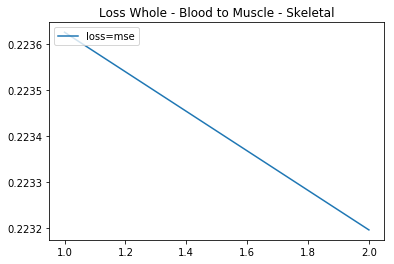

ridge


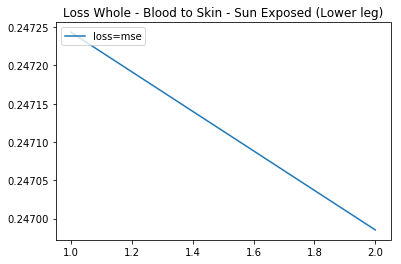

ridge


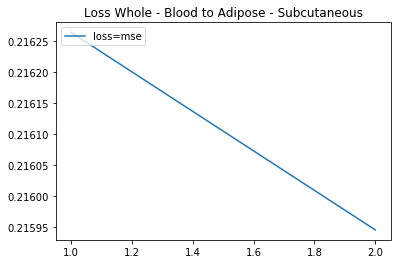

In [14]:
metrics_model4 = run_linear_model('blood',
                                  metadata_samples_train,
                                  metadata_samples_valid,
                                  x_train, y_train, 
                                  x_valid, y_valid, 
                                  'model4_optimal',
                                  'ridge',
                                  'mse', 
                                  P_train_unsorted,
                                  P_valid_unsorted, 
                                  Q,
                                  "Loss Whole - Blood to ",
                                  path_models="/s/project/rep/processed/models/linear_regression/")

In [15]:
import pickle
pickle.dump(metrics_model4, open('/s/project/rep/processed/models/linear_regression/evaluation_tissues_model4_optimal.json', "wb"))

### 4. Fit data using robust regression
To overcome the strong influence of the outliers over the regression fit we consider using the 

- (a) Huber Regression
- (b) L1-norm loss function - least absolute deviations (LAD)


#### 4.1 (a) Huber Regression

huber
loss=0.22311945965577717


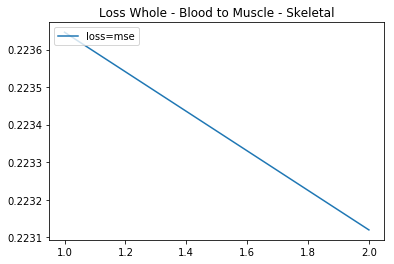

huber
loss=0.2464782362008206


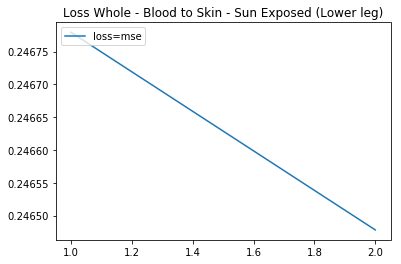

huber
loss=0.21568419179479206


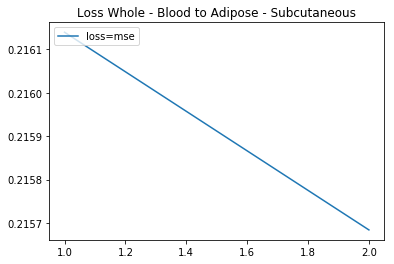

In [16]:
import re

import rep.preprocessing_new as prep
import rep.datasets as d
import rep.models_coord_descent as m
import rep.linear_regression as lr
import rep.metrics as metrics
from anndata import AnnData

import warnings
warnings.filterwarnings('ignore')

metrics_huber = run_linear_model('blood',
                                  metadata_samples_train,
                                  metadata_samples_valid,
                                  x_train, y_train, 
                                  x_valid, y_valid, 
                                  'huber_regression_optimal',
                                  'huber',
                                  'mse', 
                                  P_train_unsorted,
                                  P_valid_unsorted, 
                                  Q,
                                  "Loss Whole - Blood to ",
                                  path_models="/s/project/rep/processed/models/linear_regression/")

In [17]:
import pickle
pickle.dump(metrics_huber, open('/s/project/rep/processed/models/linear_regression/evaluation_tissues_huber_regression_optimal.json', "wb"))

#### 4.2 (b) L1-norm loss function - least absolute deviations (LAD)

In [29]:
import re
import rep.preprocessing_new as prep
import rep.datasets as d
import rep.models_coord_descent as m
import rep.linear_regression as lr
import rep.metrics as metrics
from anndata import AnnData
import pickle

import warnings
warnings.filterwarnings('ignore')


ridge
lad_mean= 0.316350151649441


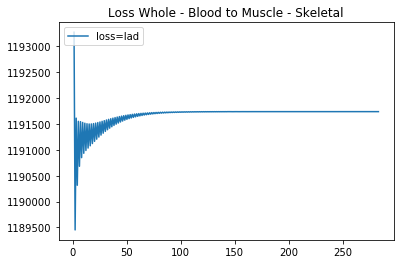

ridge
lad_mean= 0.31587951974952844


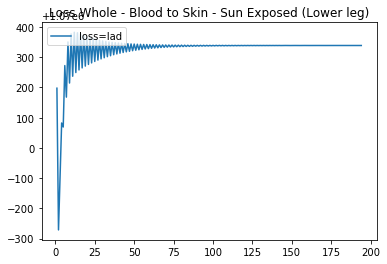

ridge
lad_mean= 0.29795072891135277


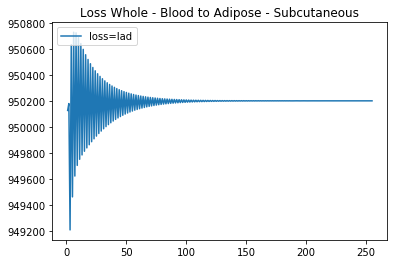

In [30]:
metrics_loss_l1 = run_linear_model('blood',
                                  metadata_samples_train,
                                  metadata_samples_valid,
                                  x_train, y_train, 
                                  x_valid, y_valid, 
                                  'l1_loss_optimal',
                                  'ridge',
                                  'lad', 
                                  P_train_unsorted,
                                  P_valid_unsorted, 
                                  Q,
                                  "Loss Whole - Blood to ",
                                  path_models="/s/project/rep/processed/models/linear_regression/")

import pickle
pickle.dump(metrics_loss_l1, open('/s/project/rep/processed/models/linear_regression/evaluation_tissues_l1_loss_optimal.json', "wb"))

#### 5. Run all models using Q computed with log2(TPMs) and not with the logRatios

ridge


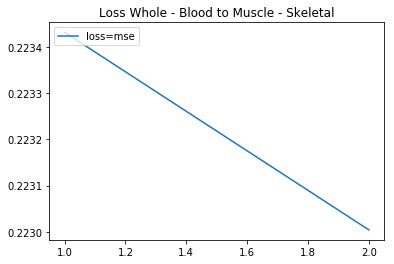

ridge


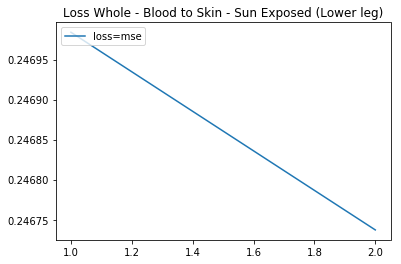

ridge


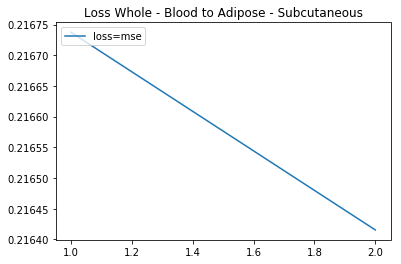

huber
loss=0.222930238700184


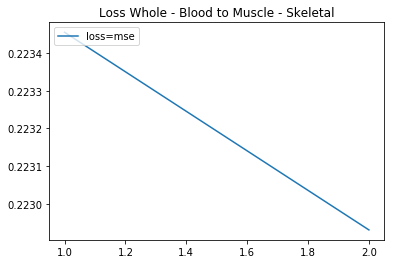

huber
loss=0.24622846312796148


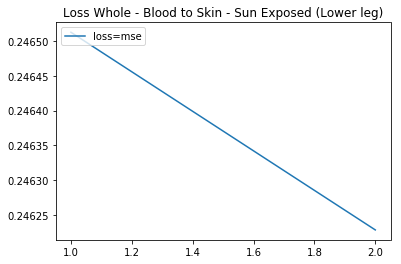

huber
loss=0.21615277870759722


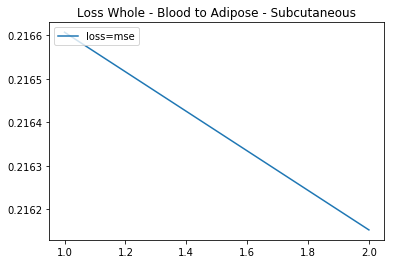

ridge
lad_mean= 0.316258532819671


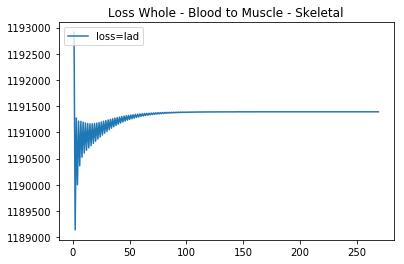

ridge
lad_mean= 0.31613565253303394


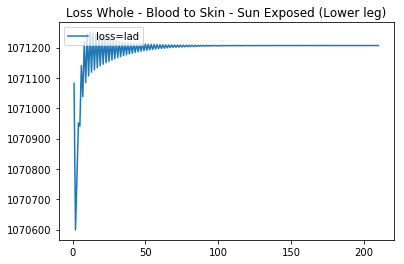

ridge
lad_mean= 0.2981254223957814


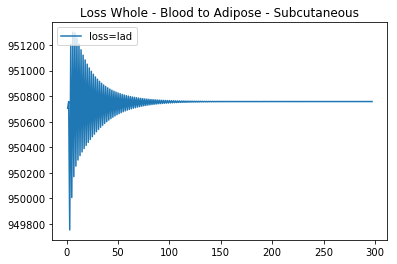

In [31]:
# model 4
metrics_model4 = run_linear_model('blood',
                                  metadata_samples_train,
                                  metadata_samples_valid,
                                  x_train, y_train, 
                                  x_valid, y_valid, 
                                  'model4_Q_tpm_optimal',
                                  'ridge',
                                  'mse', 
                                  P_train_unsorted,
                                  P_valid_unsorted, 
                                  Q_tpm_only,
                                  "Loss Whole - Blood to ",
                                  path_models="/s/project/rep/processed/models/linear_regression/")
pickle.dump(metrics_model4, open('/s/project/rep/processed/models/linear_regression/evaluation_tissues_model4_Q_tpm_optimal.json', "wb"))

# huber regressor
metrics_huber = run_linear_model('blood',
                                  metadata_samples_train,
                                  metadata_samples_valid,
                                  x_train, y_train, 
                                  x_valid, y_valid, 
                                  'huber_regression_Q_tmp_optimal',
                                  'huber',
                                  'mse', 
                                  P_train_unsorted,
                                  P_valid_unsorted, 
                                  Q_tpm_only,
                                  "Loss Whole - Blood to ",
                                  path_models="/s/project/rep/processed/models/linear_regression/")
pickle.dump(metrics_huber, open('/s/project/rep/processed/models/linear_regression/evaluation_tissues_huber_regression_Q_tmp_optimal.json', "wb"))

# loss 1

metrics_loss_l1 = run_linear_model('blood',
                                  metadata_samples_train,
                                  metadata_samples_valid,
                                  x_train, y_train, 
                                  x_valid, y_valid, 
                                  'l1_loss_Q_tpm_optimal',
                                  'ridge',
                                  'lad', 
                                  P_train_unsorted,
                                  P_valid_unsorted, 
                                  Q_tpm_only,
                                  "Loss Whole - Blood to ",
                                  path_models="/s/project/rep/processed/models/linear_regression/")

import pickle
pickle.dump(metrics_loss_l1, open('/s/project/rep/processed/models/linear_regression/evaluation_tissues_l1_loss_Q_tmp_optimal.json', "wb"))

### 6. Use the KernelPCA for computing the P and Q matrix

In [13]:
# individual effect
P_blood_all  = pca_individual_effect(gtex_filtered,pca_type=KernelPCA)
P_train_unsorted = P_blood_all[P_blood_all.obs['Individual'].isin(train_individuals)]
P_valid_unsorted = P_blood_all[P_blood_all.obs['Individual'].isin(valid_individuals)]

# gene effect
Q_tpm_only = pca_gene_effect(gtex_filtered_train_tmp,pca_type=KernelPCA)

(331, 19932)


ridge


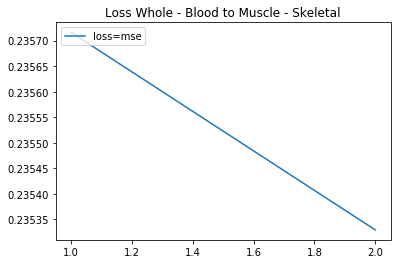

ridge


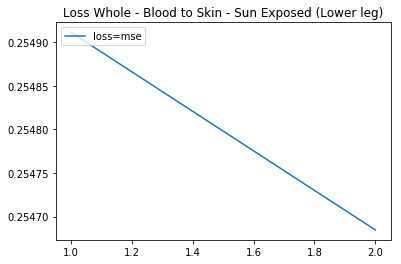

ridge


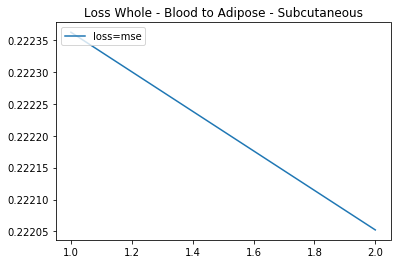

huber
loss=0.2364298197925985


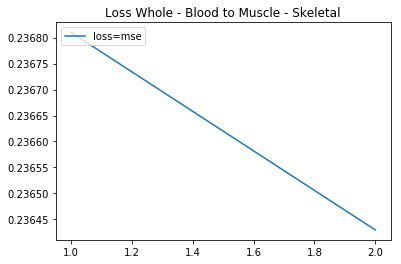

huber
loss=0.255134431976133


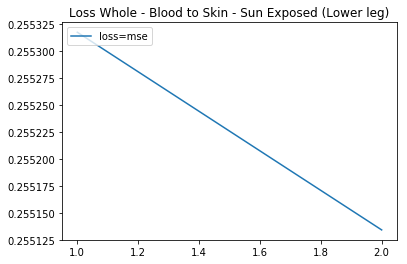

huber
loss=0.22260462731288155


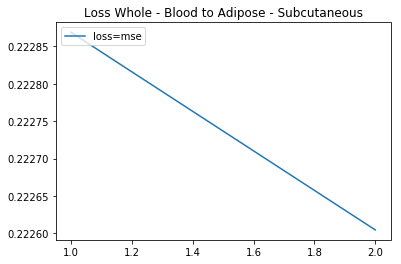

ridge
lad_mean= 0.31997560119837987


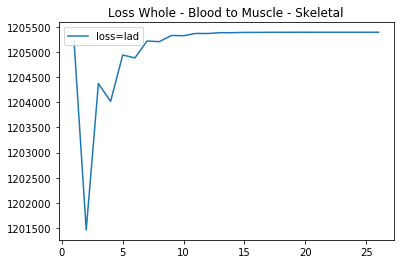

ridge
lad_mean= 0.3197613707105066


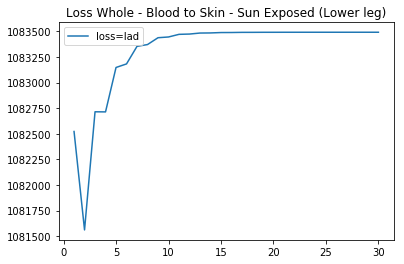

ridge
lad_mean= 0.3008585723743806


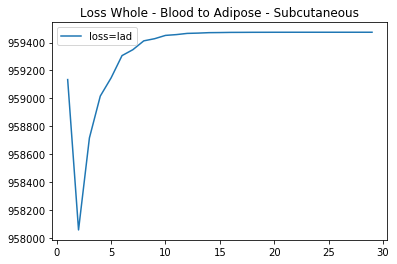

In [16]:
# model 4
metrics_model4 = run_linear_model('blood',
                                  metadata_samples_train,
                                  metadata_samples_valid,
                                  x_train, y_train, 
                                  x_valid, y_valid, 
                                  'model4_Q_tpm_kernelpca',
                                  'ridge',
                                  'mse', 
                                  P_train_unsorted,
                                  P_valid_unsorted, 
                                  Q_tpm_only,
                                  "Loss Whole - Blood to ",
                                  path_models="/s/project/rep/processed/models/linear_regression/")
pickle.dump(metrics_model4, open('/s/project/rep/processed/models/linear_regression/evaluation_tissues_model4_Q_tpm_kernelpca.json', "wb"))

# huber regressor
metrics_huber = run_linear_model('blood',
                                  metadata_samples_train,
                                  metadata_samples_valid,
                                  x_train, y_train, 
                                  x_valid, y_valid, 
                                  'huber_regression_Q_tmp_kernelpca',
                                  'huber',
                                  'mse', 
                                  P_train_unsorted,
                                  P_valid_unsorted, 
                                  Q_tpm_only,
                                  "Loss Whole - Blood to ",
                                  path_models="/s/project/rep/processed/models/linear_regression/")
pickle.dump(metrics_huber, open('/s/project/rep/processed/models/linear_regression/evaluation_tissues_huber_regression_Q_tmp_kernelpca.json', "wb"))

# loss 1

metrics_loss_l1 = run_linear_model('blood',
                                  metadata_samples_train,
                                  metadata_samples_valid,
                                  x_train, y_train, 
                                  x_valid, y_valid, 
                                  'l1_loss_Q_tpm_kernelpca',
                                  'ridge',
                                  'lad', 
                                  P_train_unsorted,
                                  P_valid_unsorted, 
                                  Q_tpm_only,
                                  "Loss Whole - Blood to ",
                                  path_models="/s/project/rep/processed/models/linear_regression/")

import pickle
pickle.dump(metrics_loss_l1, open('/s/project/rep/processed/models/linear_regression/evaluation_tissues_l1_loss_Q_tmp_kernelpca.json', "wb"))

### 7. Run models using only the genes + PCA with n_comp = 25

In [6]:
from joblib import dump, load
import numpy as np
import pandas as pd

import comet_ml
import re
from rep import models_coord_descent as m
from rep import constants as cst
from rep import linear_regression as lr
from rep import metrics
from rep import preprocessing_new as prep

from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *

import pickle

import warnings; warnings.simplefilter('ignore')
%matplotlib inline

high_expressed_genes = prep.load_list("/s/project/rep/processed/gtex/input_data/genes_subset/highly_expressed_genes.txt")
len(high_expressed_genes)

39

ridge
(220, 19932)
(220, 19932)


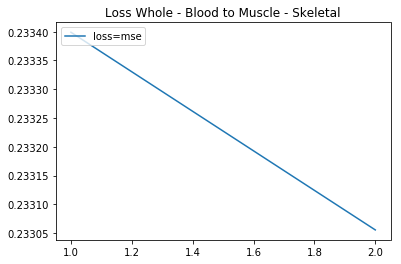

(220, 19932)
(83, 19932)
ridge
(189, 19932)
(189, 19932)


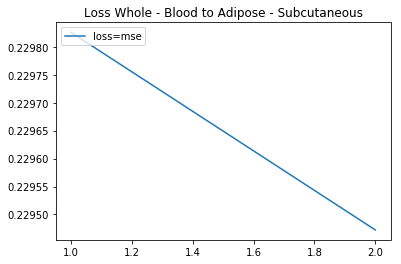

(189, 19932)
(81, 19932)
ridge
(193, 19932)
(193, 19932)


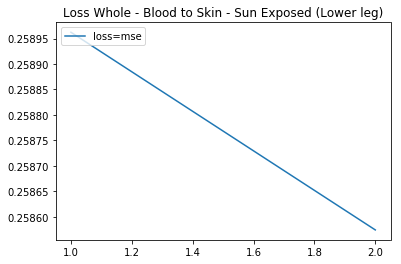

(193, 19932)
(74, 19932)
huber
(220, 19932)
(220, 19932)
(220, 19932)
loss=0.2345944418616555


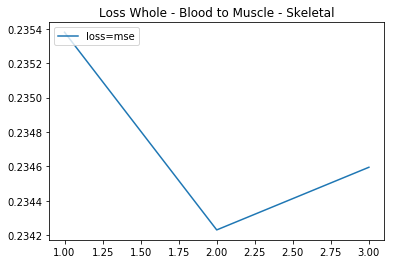

(220, 19932)
(83, 19932)
huber
(189, 19932)
(189, 19932)
loss=0.23050297033610362


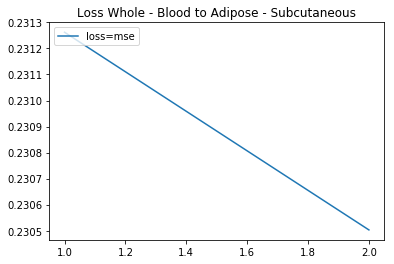

(189, 19932)
(81, 19932)
huber
(193, 19932)
(193, 19932)
loss=0.25911975784138097


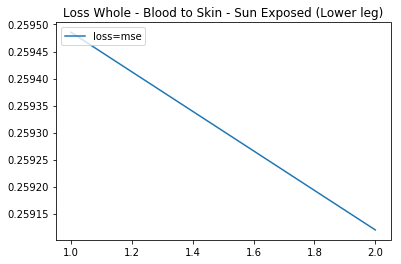

(193, 19932)
(74, 19932)
ridge
(220, 19932)
(220, 19932)
(220, 19932)
(220, 19932)
(220, 19932)
(220, 19932)


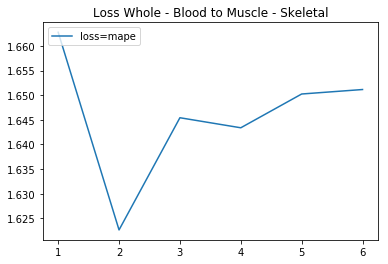

(220, 19932)
(83, 19932)
ridge
(189, 19932)
(189, 19932)
(189, 19932)
(189, 19932)
(189, 19932)
(189, 19932)


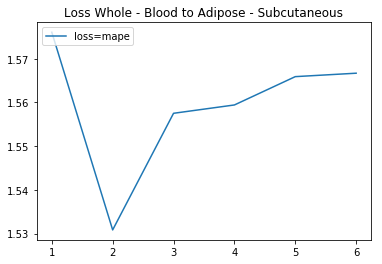

(189, 19932)
(81, 19932)
ridge
(193, 19932)
(193, 19932)
(193, 19932)
(193, 19932)


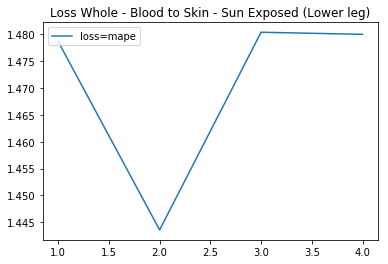

(193, 19932)
(74, 19932)


In [7]:
def run_linear_model(from_tissue_label, model_name, estimator, loss_function, title_loss_u, path_models="/s/project/rep/processed/models/linear_regression/", genes=None):
    
    tissues = ["Muscle - Skeletal", "Adipose - Subcutaneous", "Skin - Sun Exposed (Lower leg)"]
    
    dict_evaluation = {}
    dict_evaluation[from_tissue_label] = {}
    for t in tissues:

        dict_evaluation[from_tissue_label][t] = {}
        dict_evaluation[from_tissue_label][t]['train'] = {}
        dict_evaluation[from_tissue_label][t]['valid'] = {}
        # data to predict from blood to muscle
        (y_blood_train, y_train, meta_train, P_train_u, Q_u, n_genes_train, n_indiv_train), (y_blood_valid, y_valid, meta_valid, P_valid_u, Q_u, n_genes_valid, n_indiv_valid) = lr.prepare_linear_regression_input(t,
                                                                                                                                                                                                                    n_comp_indiv_effect=25,
                                                                                                                                                                                                                    n_comp_gene_effect=25,
                                                                                                                                                                                                                    gene_list=genes)
        x_train_ = y_blood_train
        y_train_ = y_train
        x_valid_ = y_blood_valid
        y_valid_ = y_valid       

        # fit
        n_indiv, n_genes = x_train_.shape
        model = m.model4(x_train_, P_train_u, Q_u, y_train_, n_genes, n_indiv, title_loss = title_loss_u + t, loss_function=loss_function, estimator=estimator)

        # save model
        tissue_name = t.lower().replace(" ","")
        tissue_name = re.sub("[-\(\)]","_", tissue_name)
        tissue_model_path = f'{path_models}{from_tissue_label}2{tissue_name}_{model_name}.joblib'
        dump(model, tissue_model_path)
        dict_evaluation[from_tissue_label][t]['model'] = tissue_model_path

        # predict on train
        n_indiv, n_genes = x_train_.shape
        y_pred = m.predict_model4(model, x_train_, P_train_u, Q_u, n_genes, n_indiv)
        dict_evaluation[from_tissue_label][t]['train']['loss'] = m.compute_loss(y_train_, y_pred)
        dict_evaluation[from_tissue_label][t]['train']['metrics'] = metrics.rep_metric(y_train_, y_pred)

        # predict on valid
        n_indiv, n_genes = x_valid_.shape
        y_pred = m.predict_model4(model, x_valid_, P_valid_u, Q_u, n_genes, n_indiv)
        dict_evaluation[from_tissue_label][t]['valid']['loss'] = m.compute_loss(y_valid_, y_pred)
        dict_evaluation[from_tissue_label][t]['valid']['metrics'] = metrics.rep_metric(y_valid_, y_pred)

    return dict_evaluation
    

# model 4
metrics_model4 = run_linear_model('blood',
                                  'coord_descent_ridge',
                                  'ridge',
                                  'mse', 
                                  "Loss Whole - Blood to ",
                                  path_models="/s/project/rep/processed/models/linear_regression/")
pickle.dump(metrics_model4, open('/s/project/rep/processed/models/linear_regression/coord_descent_ridge_pca25.json', "wb"))

# huber regressor
metrics_huber = run_linear_model('blood',
                                 'coord_descent_huber',
                                 'huber',
                                 'mse', 
                                 "Loss Whole - Blood to ",
                                 path_models="/s/project/rep/processed/models/linear_regression/")
pickle.dump(metrics_huber, open('/s/project/rep/processed/models/linear_regression/coord_descent_pca25.json', "wb"))

# loss 1

metrics_loss_l1 = run_linear_model('blood',
                                  'coord_descent_l1_loss',
                                  'ridge',
                                  'mape', 
                                  "Loss Whole - Blood to ",
                                  path_models="/s/project/rep/processed/models/linear_regression/")

import pickle
pickle.dump(metrics_loss_l1, open('/s/project/rep/processed/models/linear_regression/coord_descent_l1_loss_pca25.json', "wb"))

In [8]:
def run_linear_model(from_tissue_label, model_name, estimator, loss_function, title_loss_u, path_models="/s/project/rep/processed/models/linear_regression/", genes=None):
    
    tissues = ["Muscle - Skeletal", "Adipose - Subcutaneous", "Skin - Sun Exposed (Lower leg)"]
    
    dict_evaluation = {}
    dict_evaluation[from_tissue_label] = {}
    for t in tissues:

        dict_evaluation[from_tissue_label][t] = {}
        dict_evaluation[from_tissue_label][t]['train'] = {}
        dict_evaluation[from_tissue_label][t]['valid'] = {}
        # data to predict from blood to muscle
        (y_blood_train, y_train, meta_train, P_train_u, Q_u, n_genes_train, n_indiv_train), (y_blood_valid, y_valid, meta_valid, P_valid_u, Q_u, n_genes_valid, n_indiv_valid) = lr.prepare_linear_regression_input(t,
                                                                                                                                                                                                                    n_comp_indiv_effect=25,
                                                                                                                                                                                                                    n_comp_gene_effect=25,
                                                                                                                                                                                                                    gene_list=genes)
        x_train_ = y_blood_train
        y_train_ = y_train
        x_valid_ = y_blood_valid
        y_valid_ = y_valid
        
        

        # fit
        n_indiv, n_genes = x_train_.shape
        model = m.model2(x_train_, y_train_, n_genes, fit_intercept = False, type_estimator=estimator)

        # save model
        tissue_name = t.lower().replace(" ","")
        tissue_name = re.sub("[-\(\)]","_", tissue_name)
        tissue_model_path = f'{path_models}{from_tissue_label}2{tissue_name}_{model_name}.joblib'
        dump(model, tissue_model_path)
        dict_evaluation[from_tissue_label][t]['model'] = tissue_model_path

        # predict on train
        n_indiv, n_genes = x_train_.shape
        y_pred = m.predict_model2(model, x_train_)
        dict_evaluation[from_tissue_label][t]['train']['loss'] = m.compute_loss(y_train_, y_pred)
        dict_evaluation[from_tissue_label][t]['train']['metrics'] = metrics.rep_metric(y_train_, y_pred)

        # predict on valid
        n_indiv, n_genes = x_valid_.shape
        y_pred = m.predict_model2(model, x_valid_)
        dict_evaluation[from_tissue_label][t]['valid']['loss'] = m.compute_loss(y_valid_, y_pred)
        dict_evaluation[from_tissue_label][t]['valid']['metrics'] = metrics.rep_metric(y_valid_, y_pred)

    return dict_evaluation
    

# model 4
metrics_model4 = run_linear_model('blood',
                                  'model2_ridge',
                                  'ridge',
                                  'mse', 
                                  "Loss Whole - Blood to ",
                                  path_models="/s/project/rep/processed/models/linear_regression/")
pickle.dump(metrics_model4, open('/s/project/rep/processed/models/linear_regression/model2_pca25.json', "wb"))

# huber regressor
metrics_huber = run_linear_model('blood',
                                 'model2_huber',
                                 'huber',
                                 'mse', 
                                 "Loss Whole - Blood to ",
                                 path_models="/s/project/rep/processed/models/linear_regression/")
pickle.dump(metrics_huber, open('/s/project/rep/processed/models/linear_regression/model2_pca25.json', "wb"))

# loss 1

metrics_loss_l1 = run_linear_model('blood',
                                  'model2_l1_loss',
                                  'ridge',
                                  'mape', 
                                  "Loss Whole - Blood to ",
                                  path_models="/s/project/rep/processed/models/linear_regression/")

import pickle
pickle.dump(metrics_loss_l1, open('/s/project/rep/processed/models/linear_regression/model2_l1_loss_pca25.json', "wb"))

(220, 19932)
(83, 19932)
(189, 19932)
(81, 19932)
(193, 19932)
(74, 19932)
(220, 19932)
(83, 19932)
(189, 19932)
(81, 19932)
(193, 19932)
(74, 19932)
(220, 19932)
(83, 19932)
(189, 19932)
(81, 19932)
(193, 19932)
(74, 19932)


### 8. Run the simplest model (no PCA for indiv or gene effect) using raw log2(TPM) over the subset of candidates genes

In [2]:
from joblib import dump, load
import numpy as np
import pandas as pd

import comet_ml
import re
from rep import models_coord_descent as m
from rep import constants as cst
from rep import linear_regression as lr
from rep import metrics
from rep import preprocessing_new as prep

from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *

import pickle

import warnings; warnings.simplefilter('ignore')
%matplotlib inline

/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:
high_expressed_genes = prep.load_list("/s/project/rep/processed/gtex/input_data/genes_subset/candidate_genes.txt")

In [4]:
high_expressed_genes[:10]

['ENSG00000163081.2',
 'ENSG00000204701.1',
 'ENSG00000171180.1',
 'ENSG00000100593.17',
 'ENSG00000184293.7',
 'ENSG00000172733.11',
 'ENSG00000143512.12',
 'ENSG00000236398.2',
 'ENSG00000276903.1',
 'ENSG00000161270.19']

In [5]:
def run_linear_model(from_tissue_label, model_name, estimator, loss_function, title_loss_u, path_models="/s/project/rep/processed/models/linear_regression/", genes=None):
    
    tissues = ["Muscle - Skeletal", "Adipose - Subcutaneous", "Skin - Sun Exposed (Lower leg)"]
    
    dict_evaluation = {}
    dict_evaluation[from_tissue_label] = {}
    for t in tissues:

        dict_evaluation[from_tissue_label][t] = {}
        dict_evaluation[from_tissue_label][t]['train'] = {}
        dict_evaluation[from_tissue_label][t]['valid'] = {}
        # data to predict from blood to muscle
        (y_blood_train, y_train, meta_train, P_train_u, Q_u, n_genes_train, n_indiv_train), (y_blood_valid, y_valid, meta_valid, P_valid_u, Q_u, n_genes_valid, n_indiv_valid) = lr.prepare_linear_regression_input(t,
                                                                                                                                                                                                                    n_comp_indiv_effect=25,
                                                                                                                                                                                                                    n_comp_gene_effect=25,
                                                                                                                                                                                                                    gene_list=genes)
        x_train_ = y_blood_train
        y_train_ = y_train
        x_valid_ = y_blood_valid
        y_valid_ = y_valid
        
        

        # fit
        n_indiv, n_genes = x_train_.shape
        model = m.model2(x_train_, y_train_, n_genes, fit_intercept = False, type_estimator=estimator)

        # save model
        tissue_name = t.lower().replace(" ","")
        tissue_name = re.sub("[-\(\)]","_", tissue_name)
        tissue_model_path = f'{path_models}{from_tissue_label}2{tissue_name}_{model_name}.joblib'
        dump(model, tissue_model_path)
        dict_evaluation[from_tissue_label][t]['model'] = tissue_model_path

        # predict on train
        n_indiv, n_genes = x_train_.shape
        y_pred = m.predict_model2(model, x_train_)
        dict_evaluation[from_tissue_label][t]['train']['loss'] = m.compute_loss(y_train_, y_pred)
        dict_evaluation[from_tissue_label][t]['train']['metrics'] = metrics.rep_metric(y_train_, y_pred)

        # predict on valid
        n_indiv, n_genes = x_valid_.shape
        y_pred = m.predict_model2(model, x_valid_)
        dict_evaluation[from_tissue_label][t]['valid']['loss'] = m.compute_loss(y_valid_, y_pred)
        dict_evaluation[from_tissue_label][t]['valid']['metrics'] = metrics.rep_metric(y_valid_, y_pred)

    return dict_evaluation
    

# model 4
metrics_model4 = run_linear_model('blood',
                                  'model2_ridge_logtmp',
                                  'ridge',
                                  'mse', 
                                  "Loss Whole - Blood to ",
                                  path_models="/s/project/rep/processed/models/linear_regression/",
                                 genes=high_expressed_genes)
pickle.dump(metrics_model4, open('/s/project/rep/processed/models/linear_regression/model2_ridge_pca25_logtpm.json', "wb"))

# huber regressor
metrics_huber = run_linear_model('blood',
                                 'model2_huber_logtmp',
                                 'huber',
                                 'mse', 
                                 "Loss Whole - Blood to ",
                                 path_models="/s/project/rep/processed/models/linear_regression/",
                                 genes=high_expressed_genes)
pickle.dump(metrics_huber, open('/s/project/rep/processed/models/linear_regression/model2_huber_pca25_logtpm.json', "wb"))

# loss 1

metrics_loss_l1 = run_linear_model('blood',
                                  'model2_l1_loss_logtmp',
                                  'ridge',
                                  'mape', 
                                  "Loss Whole - Blood to ",
                                  path_models="/s/project/rep/processed/models/linear_regression/",
                                 genes=high_expressed_genes)


pickle.dump(metrics_loss_l1, open('/s/project/rep/processed/models/linear_regression/model2_l1_loss_pca25_logtpm.json', "wb"))

In [11]:
def run_linear_model(from_tissue_label, model_name, estimator, loss_function, title_loss_u, path_models="/s/project/rep/processed/models/linear_regression/", genes=None):
    
    tissues = ["Muscle - Skeletal", "Adipose - Subcutaneous", "Skin - Sun Exposed (Lower leg)"]
    
    dict_evaluation = {}
    dict_evaluation[from_tissue_label] = {}
    for t in tissues:

        dict_evaluation[from_tissue_label][t] = {}
        dict_evaluation[from_tissue_label][t]['train'] = {}
        dict_evaluation[from_tissue_label][t]['valid'] = {}
        # data to predict from blood to muscle
        (y_blood_train, y_train, meta_train, P_train_u, Q_u, n_genes_train, n_indiv_train), (y_blood_valid, y_valid, meta_valid, P_valid_u, Q_u, n_genes_valid, n_indiv_valid) = lr.prepare_linear_regression_input(t,
                                                                                                                                                                                                                    n_comp_indiv_effect=25,
                                                                                                                                                                                                                    n_comp_gene_effect=25,
                                                                                                                                                                                                                    gene_list=genes)
        x_train_ = y_blood_train
        y_train_ = y_train
        x_valid_ = y_blood_valid
        y_valid_ = y_valid       

        # fit
        n_indiv, n_genes = x_train_.shape
        model = m.model4(x_train_, P_train_u, Q_u, y_train_, n_genes, n_indiv, title_loss = title_loss_u + t, loss_function=loss_function, estimator=estimator)

        # save model
        tissue_name = t.lower().replace(" ","")
        tissue_name = re.sub("[-\(\)]","_", tissue_name)
        tissue_model_path = f'{path_models}{from_tissue_label}2{tissue_name}_{model_name}.joblib'
        dump(model, tissue_model_path)
        dict_evaluation[from_tissue_label][t]['model'] = tissue_model_path

        # predict on train
        n_indiv, n_genes = x_train_.shape
        y_pred = m.predict_model4(model, x_train_, P_train_u, Q_u, n_genes, n_indiv)
        dict_evaluation[from_tissue_label][t]['train']['loss'] = m.compute_loss(y_train_, y_pred)
        dict_evaluation[from_tissue_label][t]['train']['metrics'] = metrics.rep_metric(y_train_, y_pred)

        # predict on valid
        n_indiv, n_genes = x_valid_.shape
        y_pred = m.predict_model4(model, x_valid_, P_valid_u, Q_u, n_genes, n_indiv)
        dict_evaluation[from_tissue_label][t]['valid']['loss'] = m.compute_loss(y_valid_, y_pred)
        dict_evaluation[from_tissue_label][t]['valid']['metrics'] = metrics.rep_metric(y_valid_, y_pred)

    return dict_evaluation
    

# model 4
metrics_model4 = run_linear_model('blood',
                                  'coord_descent_ridge_log_tmp',
                                  'ridge',
                                  'mse', 
                                  "Loss Whole - Blood to ",
                                  path_models="/s/project/rep/processed/models/linear_regression/",
                                 genes=high_expressed_genes)
pickle.dump(metrics_model4, open('/s/project/rep/processed/models/linear_regression/coord_descent_ridge_pca25_log_tmp.json', "wb"))

# huber regressor
metrics_huber = run_linear_model('blood',
                                 'coord_descent_huber_log_tmp.',
                                 'huber',
                                 'mse', 
                                 "Loss Whole - Blood to ",
                                 path_models="/s/project/rep/processed/models/linear_regression/",
                                 genes=high_expressed_genes)
pickle.dump(metrics_huber, open('/s/project/rep/processed/models/linear_regression/coord_descent_pca25_log_tmp.json', "wb"))

# loss 1

metrics_loss_l1 = run_linear_model('blood',
                                  'coord_descent_l1_loss_log_tmp.',
                                  'ridge',
                                  'mape', 
                                  "Loss Whole - Blood to ",
                                  path_models="/s/project/rep/processed/models/linear_regression/",
                                 genes=high_expressed_genes)

import pickle
pickle.dump(metrics_loss_l1, open('/s/project/rep/processed/models/linear_regression/coord_descent_l1_loss_pca25_log_tmp.json', "wb"))

[autoreload of rep.preprocessing_new failed: Traceback (most recent call last):
  File "/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 392, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 329, in update_generic
    update(a, b)
  File "/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 265, in update_function
    setattr(old, name, getattr(new, name))
ValueError: load_list() requires a code object with 0 free vars, not 5
]
[autoreload of rep.models failed: Traceback (most recent call last):
  File "/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-pack

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
ridge


ValueError: array must not contain infs or NaNs